# Time series forescasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin

In [52]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-02-11 09:05:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2025-02-11 09:06:00 (5.05 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Import time series with pandas

In [53]:
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"]) #parse the date column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [55]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [56]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~ 8 years bt there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or valuee of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [57]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


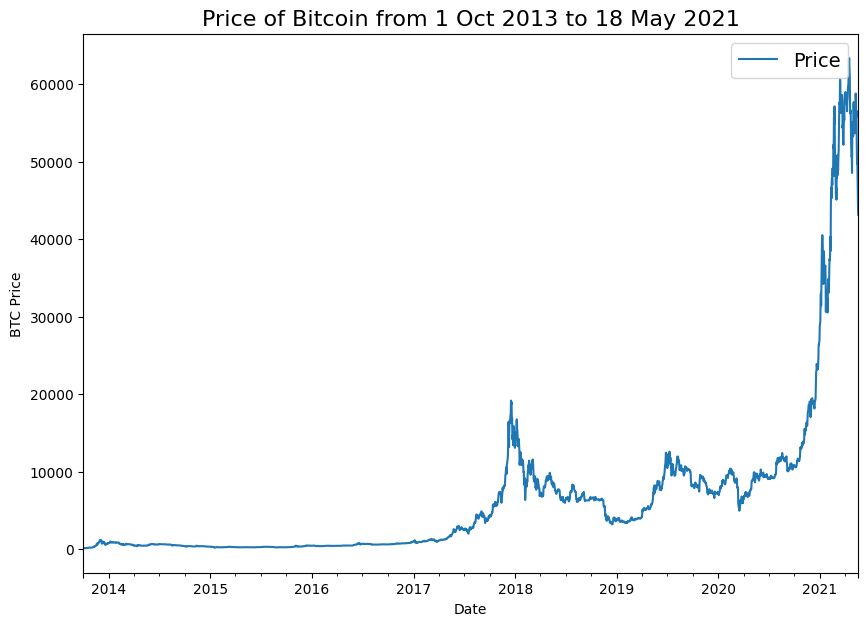

In [58]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);


## Importing time series data with Python's CSV module

In [59]:
import csv
with open ("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  line_count = 0
  for row in csv_reader:
    if line_count == 0:
      print(f"Column names are {', '.join(row)}")
      line_count += 1
  print(f"Processed {line_count} lines")

Column names are Currency, Date, Closing Price (USD), 24h Open (USD), 24h High (USD), 24h Low (USD)
Processed 1 lines


In [60]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = [] # it's going to store our times
btc_prices = [] # store our prices
with open ("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) #get the dates as dates not strings
    btc_prices.append(float(line[2])) # gt the closing prices as a float

# Viwe first 10 of each
timesteps[:10], btc_prices[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

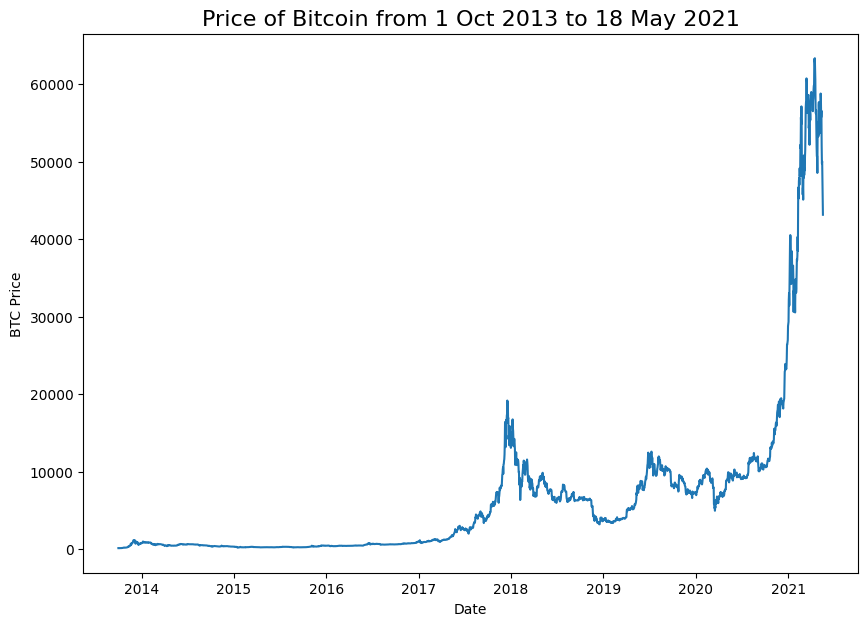

In [61]:
# Plot from csv
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_prices)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our tiem series data

### Creating train and test sets with time series data (the wrong way)

In [62]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [63]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

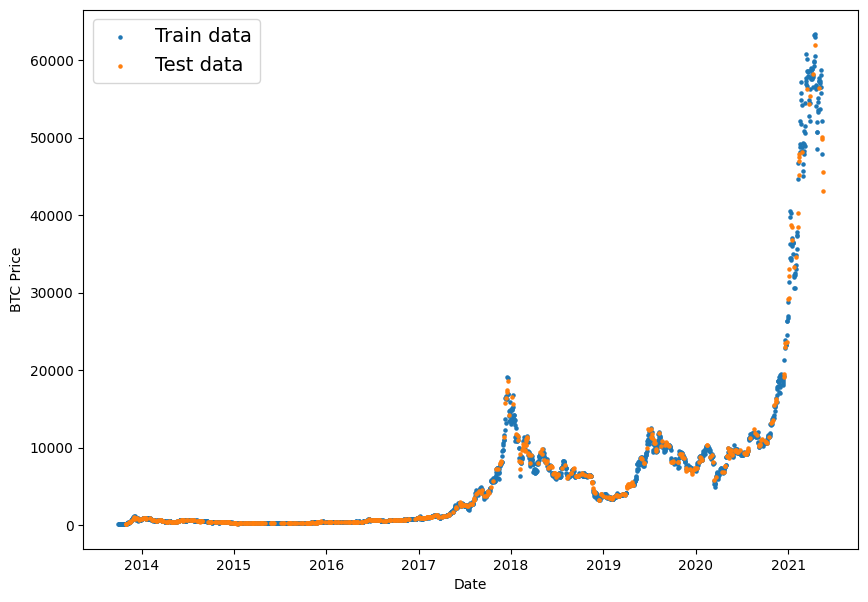

In [64]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

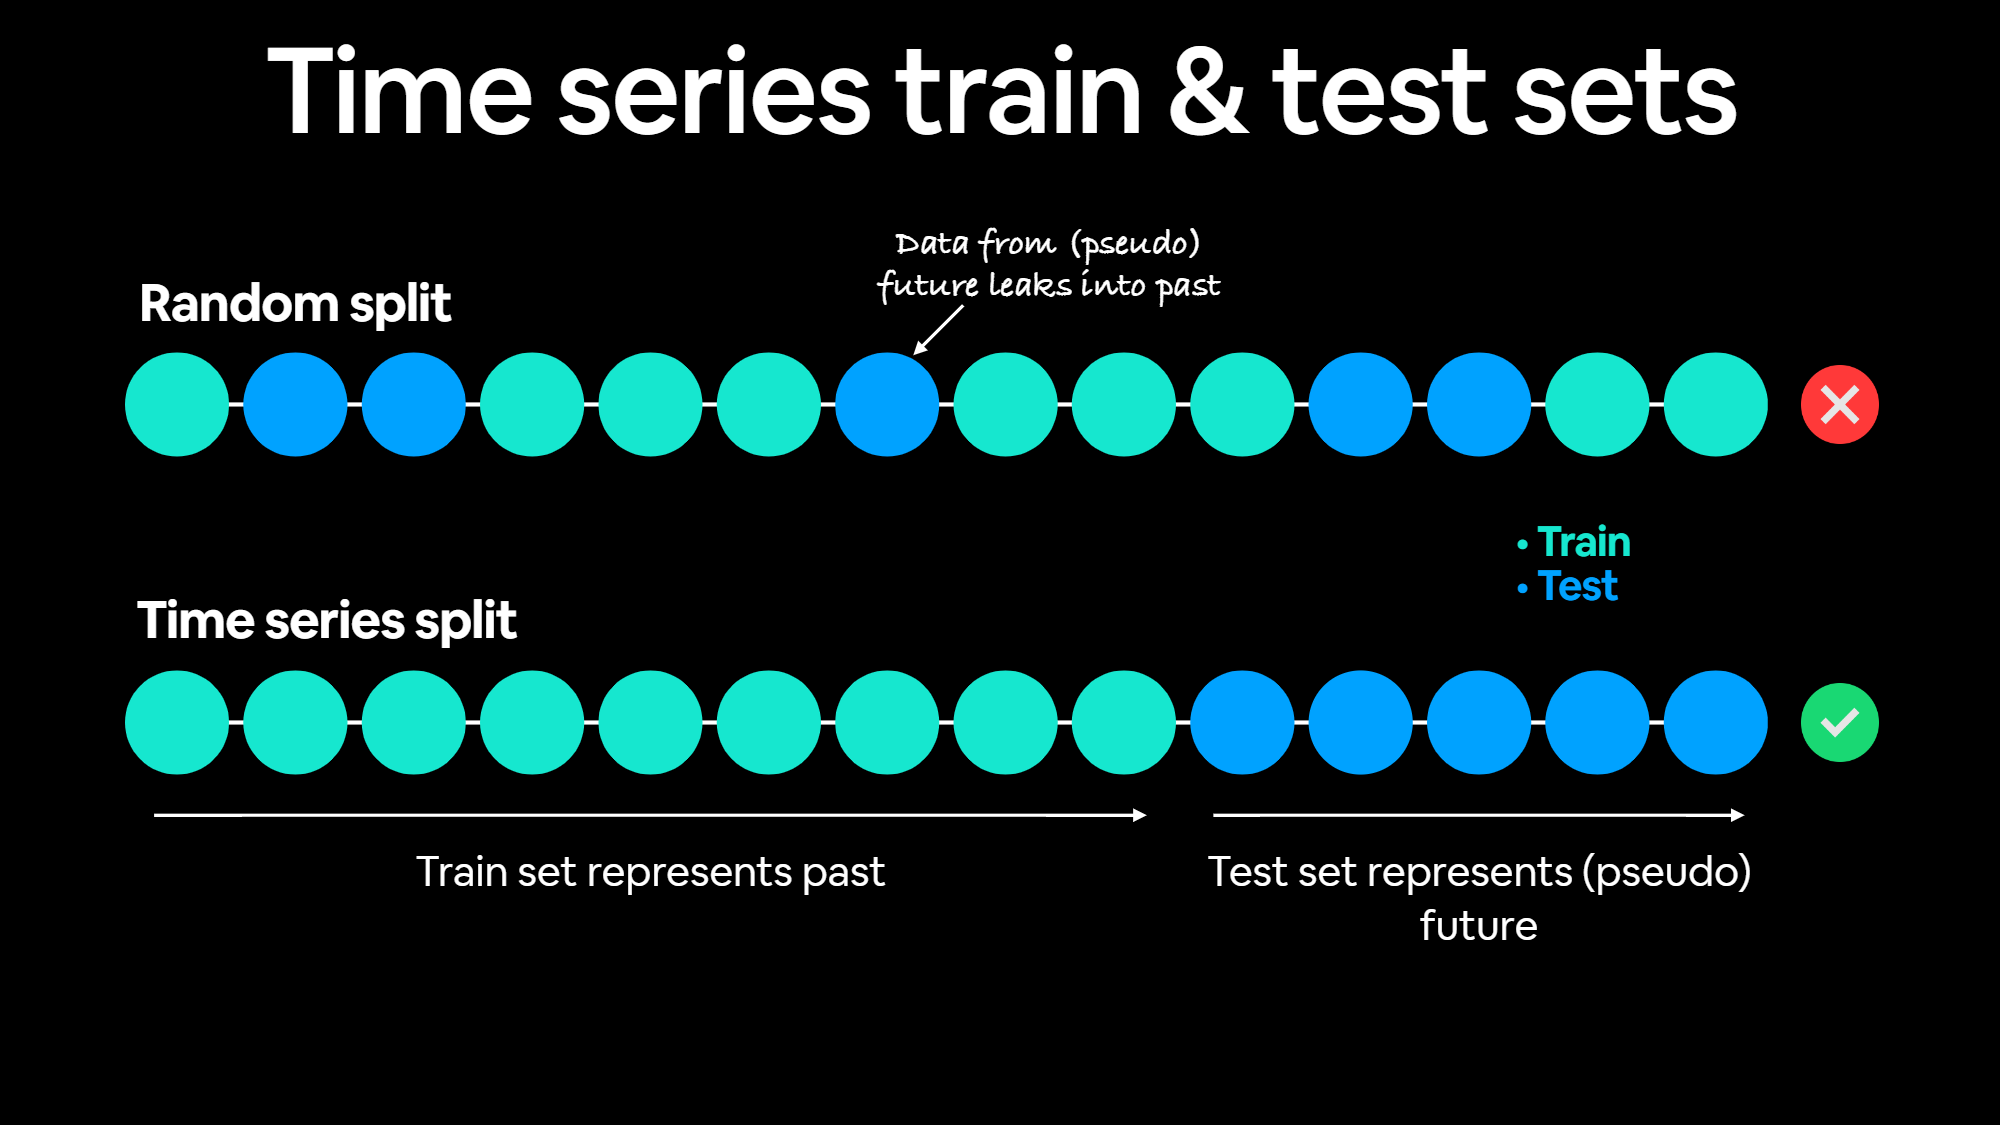

In [65]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80%, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

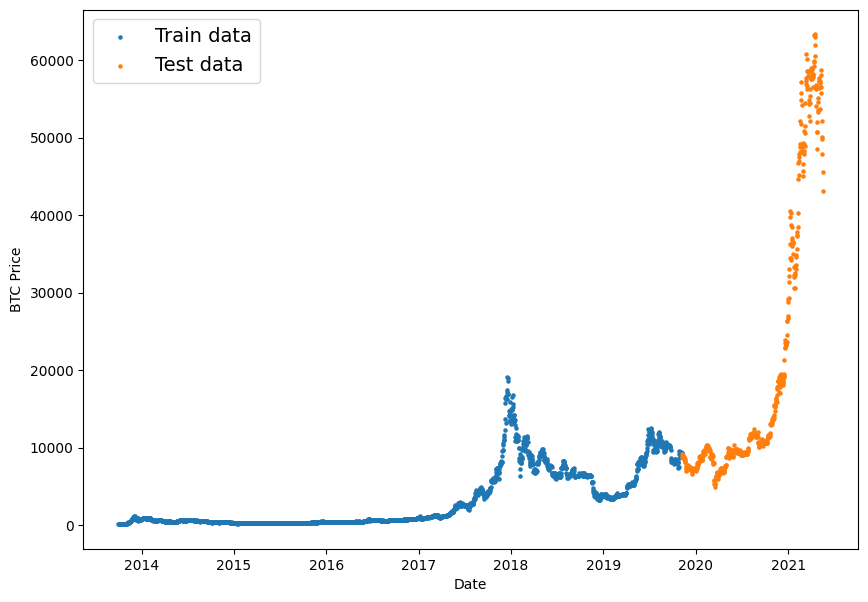

In [66]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's create a function for it.

In [67]:
# Create a function to plot time sries data
def plot_time_series(timesteps, values, format=".", start=0, end = None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  -----------
  timesteps: array of timesteps values
  values: array of values acrros time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

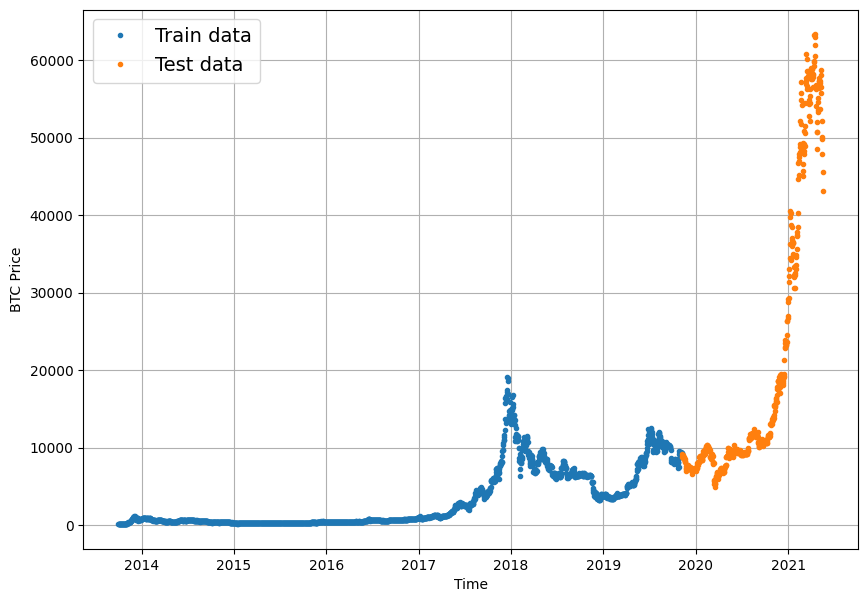

In [68]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_train, values = y_train, label = "Train data")
plot_time_series(timesteps=X_test, values = y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

These are hyperparameters that you can tune.

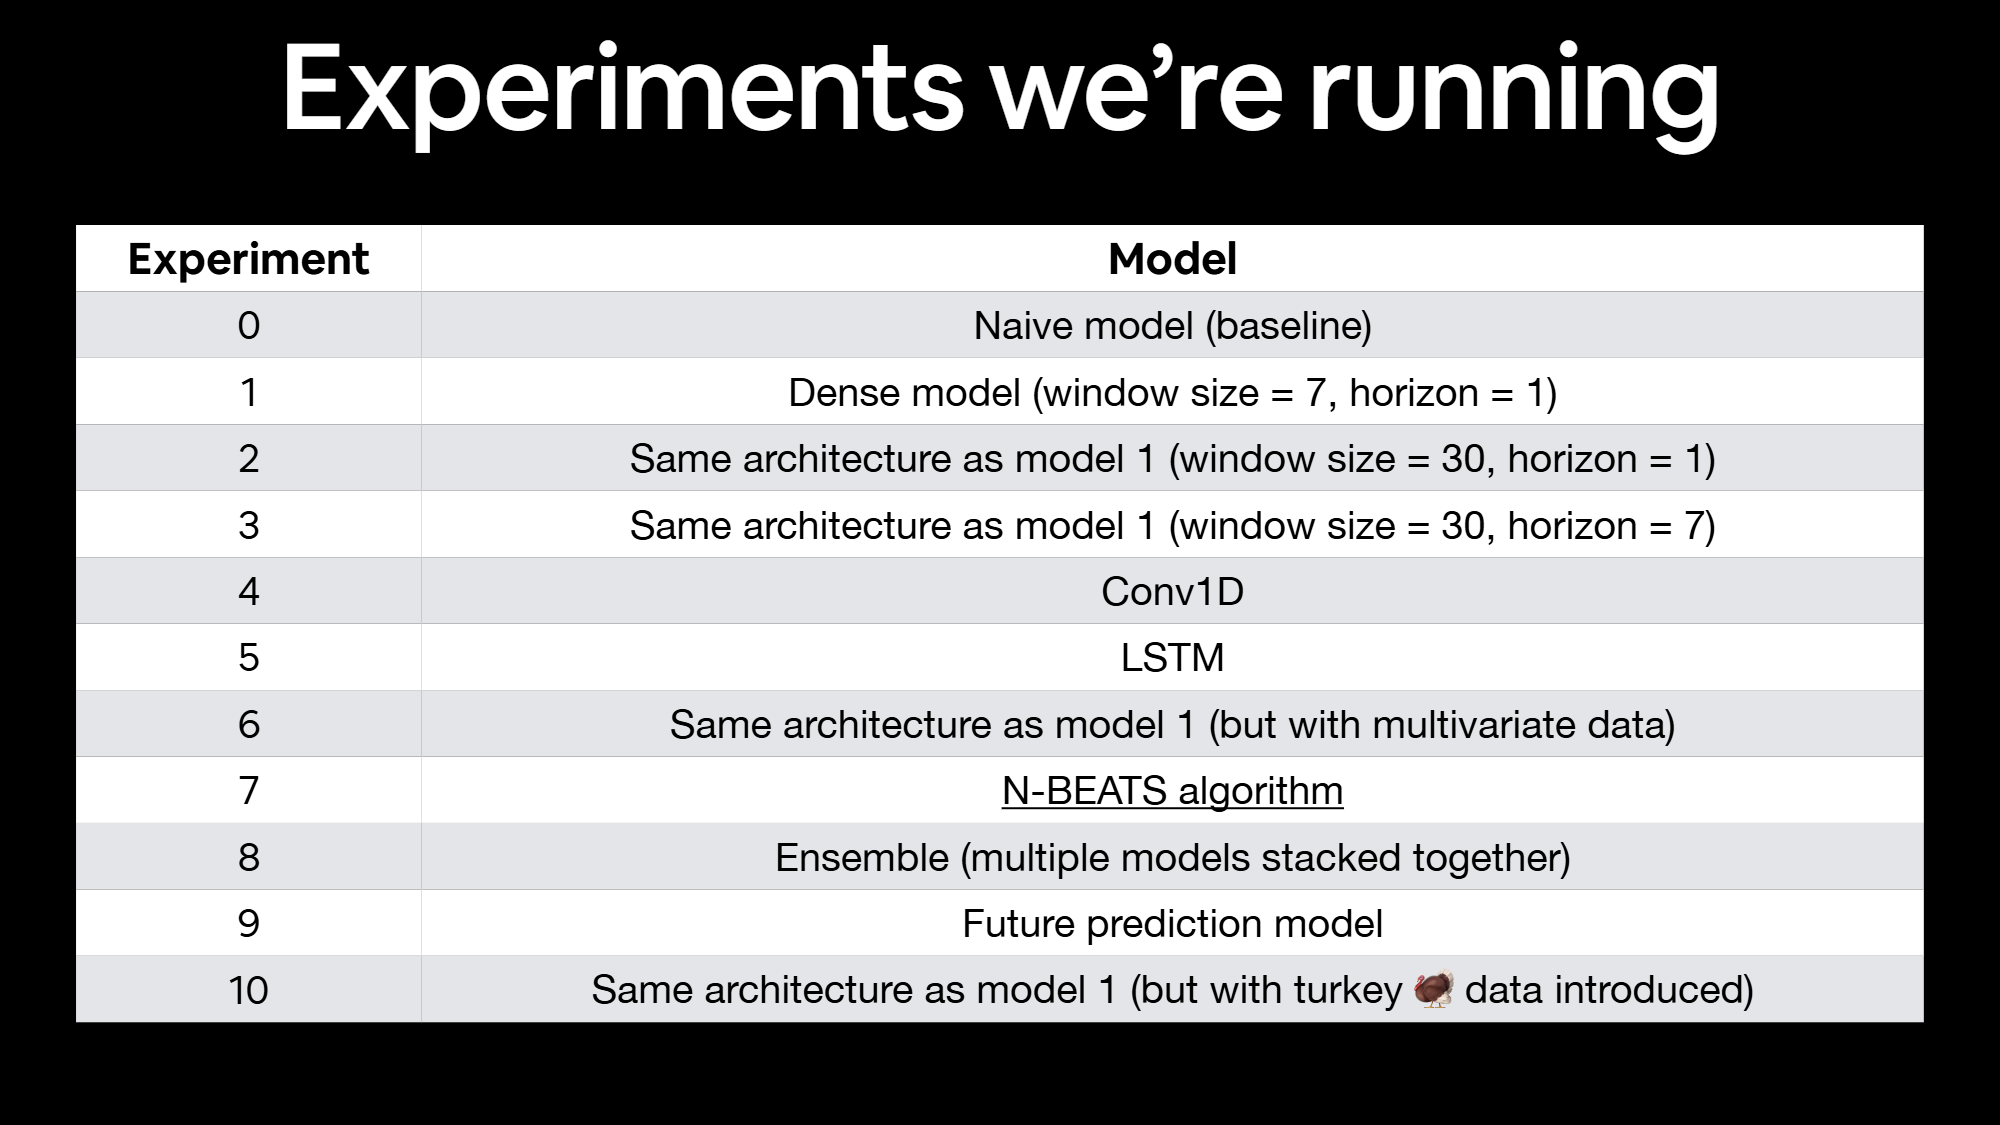

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} == y_{t-1}$$

In English:

> The prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for horizon = 1.

In [69]:
# Create a naive forecast
naive_forescast = y_test[:-1]

naive_forescast[:10], naive_forescast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

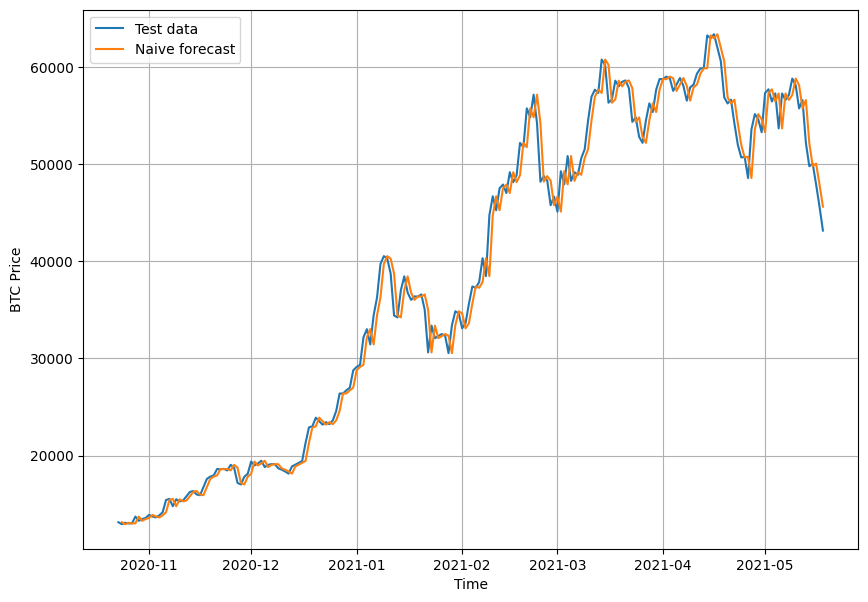

In [70]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350,format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forescast, start=350, format="-", label="Naive forecast")
plt.legend()
plt.show()

We can see the Naive Forecast follows the test data quite closely. This makes sense since we're not actually building a model, we're just offsetting the `y_test` values by 1 index. As we'll see building future models, it's actually quite difficult to beat this naive forecast baseline.

> ⚒ **Exercise:** Spend 10 minutes reading the simple forecast chapter of Forecasting: Principles in Practice. And have a search to find out why the naive forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression poblem, we'll need some regression-like metrics.

A few common regression metrics (which can algo be used for time series forecasting):
* MAE - mean absolute error (`tf.keras.losses.MAE()`)
* MSE - mean squared error (`tf.keras.losses.MSE()`)
* RMSE - root mean squared error
* MAPE/sMAPE - (scaled) mean absolute percentage erro
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example,, an MAE of 0 is better than a MAE of 100

The main thing we're evaluating here is: **how do our model's forecast (y_pred) compare against the actual values (y_true or ground truth values)?**

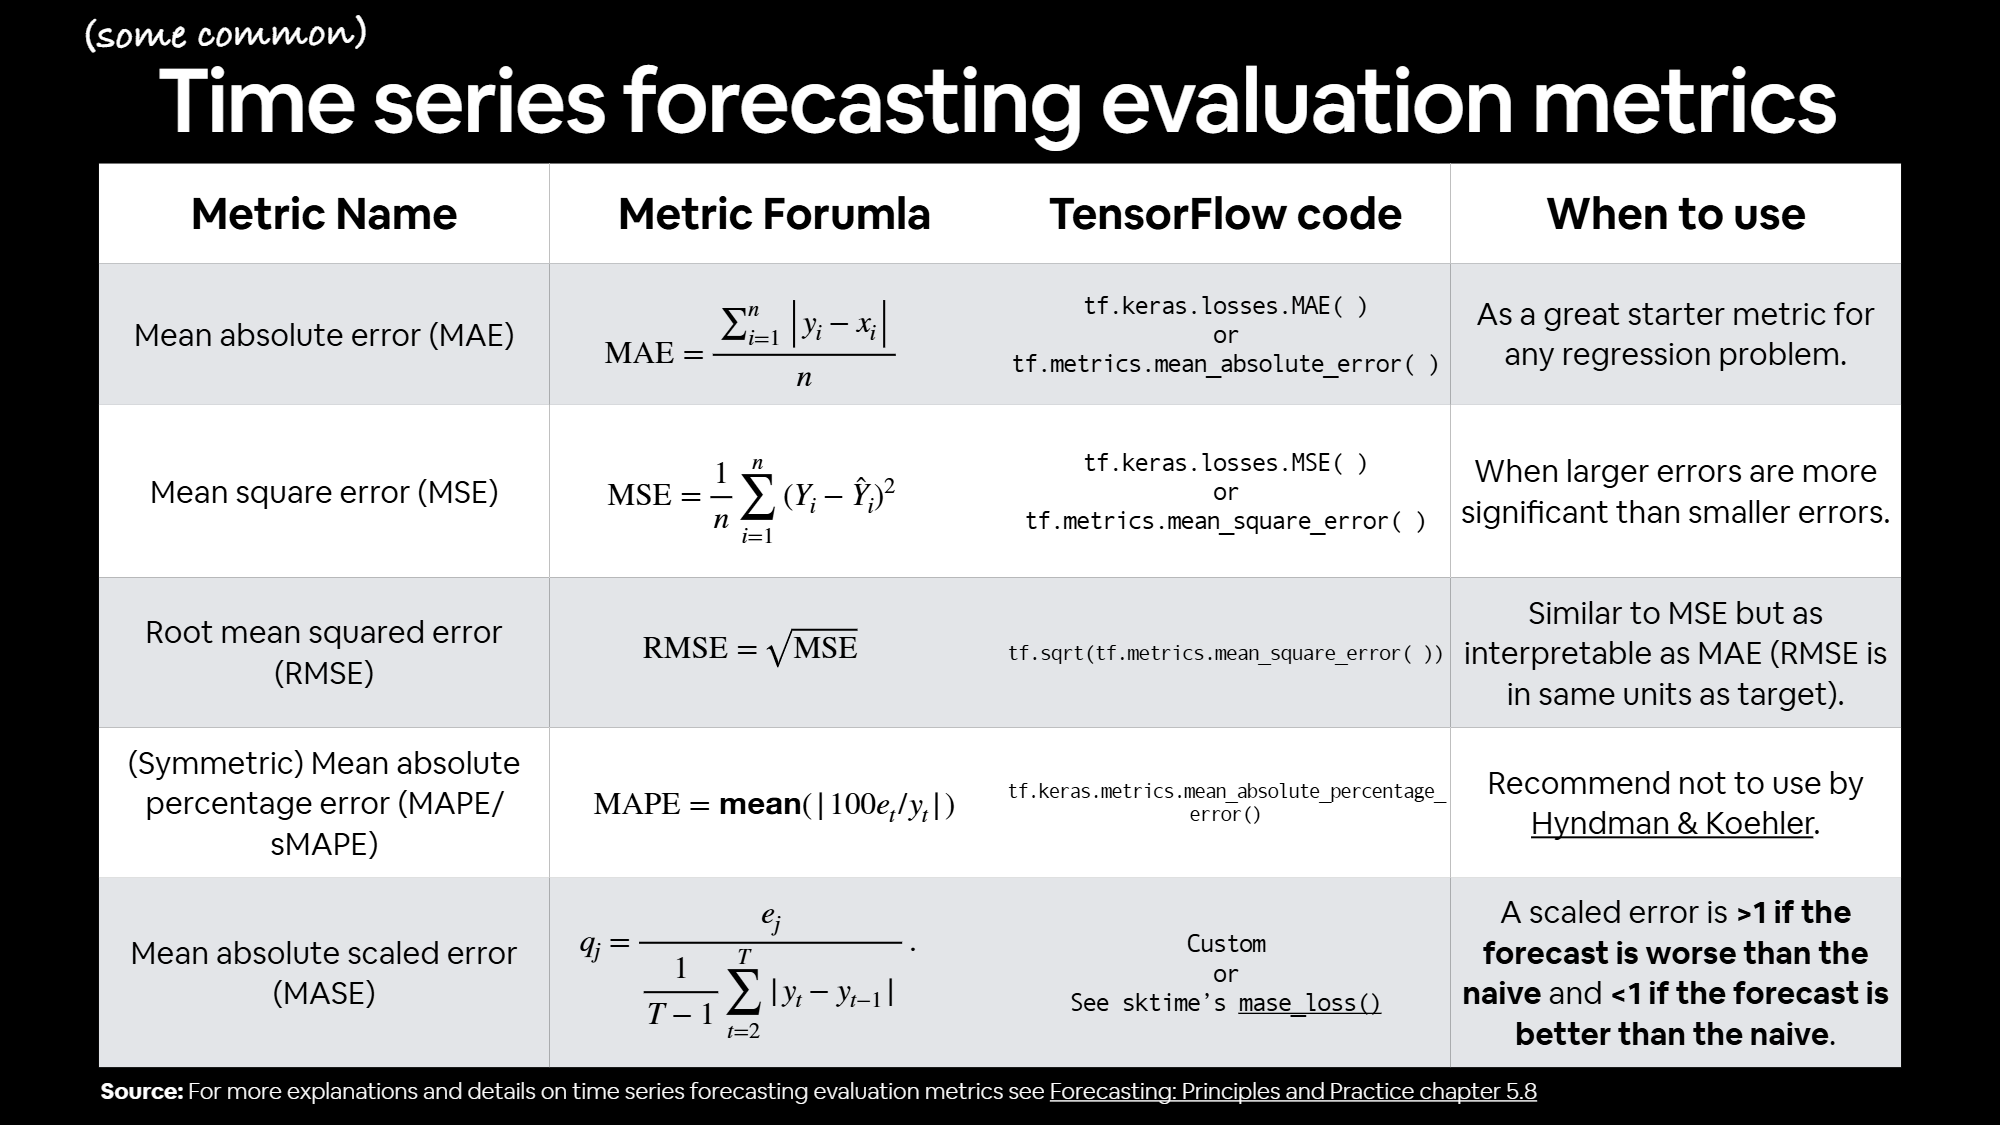

In [71]:
!pip install tensorflow==2.15.0

In [72]:
import tensorflow as tf

In [73]:
# MASE imprementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonlaity is 1 day (hence the shift of 1)

  return mae/mae_naive_no_season

In [74]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forescast).numpy()

0.9995699939182624

In [75]:
# Create a function to take in model predictions and truth values and return evaluation
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluations metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works...

In [76]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forescast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Other models you can use for baseline and for actual forecast

In this notebook, we're focused on TensorFlow and depp learning models.

However there are plenty of other styles of time series forecasting models you want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts


## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [77]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_prices[:7]} to predidict this: {btc_prices[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predidict this: 123.033


In [78]:
# Let's setup global variables for window and horizon size
HORIZON = 1 #predict next 1 day
WINDOW_SIZE = 7 #use the past week of Bitcoin data to make prediction

In [79]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:,-horizon:]

In [80]:
# Test out our function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've gt a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, fo large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple window steps for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [81]:
import numpy as np

# Create function to view Numpy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with
  horizon size labels.
  """

  # 1. Create a window of specific window_size(add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)

  # 2. Create a 2D array of multiple window steps(minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [82]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [83]:
# View the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]} -> Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [84]:
# View the last 3 windows/labels
for i in range(3):
   print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑**Note:** There's a function which does similar to the above in `tf.keras.preprocessing`, an extension could be to try and replicate what we've done using the premade function:https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets


In [85]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [86]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) #this will default to 80%train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [87]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [88]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [89]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [90]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [91]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I pick them out of experimentation.

*  *Hyperparameters* = values a machine learning practioner can adjust themselves
* *Parameters* = values a model learns on its own


In [92]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 2s 35ms/step - loss: 2364.0745 - mae: 2364.0745 - val_loss: 2309.3079 - val_mae: 2309.3079
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 408.3076 - mae: 408.3076 - val_loss: 1759.0115 - val_mae: 1759.0115
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 256.8853 - mae: 256.8853 - val_loss: 1207.9261 - val_mae: 1207.9261
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 212.1757 - mae: 212.1757 - val_loss: 1145.1686 - val_mae: 1145.1686
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 205.9922 - mae: 205.9922 - val_loss: 1149.5913 - val_mae: 1149.5913
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 198.6100 - mae: 198.6100 - val_loss: 1118.6660 - val_mae: 1118.6660
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 195.6340 - mae: 195.6340 - val_loss: 1098.7588 - val_mae: 1098.7588
Epoch

In [93]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 712.7104 - mae: 712.7104


[712.7103881835938, 712.7103881835938]

In [94]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 562.7422 - mae: 562.7422


[562.7422485351562, 562.7422485351562]

## Making forecast with a model (on the test dataset)


To make "forecast" on the test dataset( note: these won't be actual forecast, they're only pseudo forecast because actual forecast are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [95]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [96]:
# Make predictions using model_1 on the test dataset
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8853.215 , 8820.503 , 9065.887 , 8787.418 , 8773.2295, 8740.546 ,
        8685.334 , 8569.331 , 8460.717 , 8555.098 ], dtype=float32)>)

In [97]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 562.74225,
 'mse': 1152376.6,
 'rmse': 1073.488,
 'mape': 2.5171854,
 'mase': 0.98858225}

In [98]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

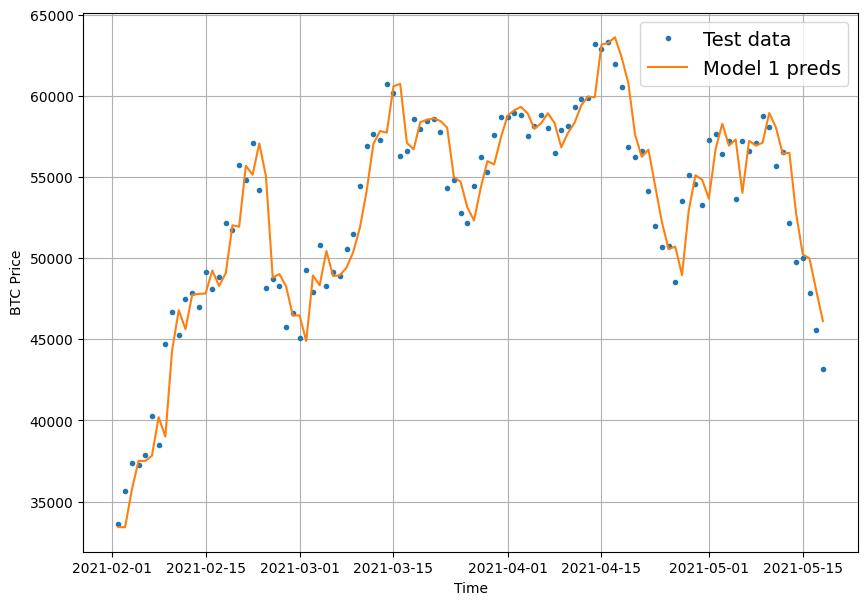

In [99]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= model_1_preds,
                 start = offset,
                 format="-",
                 label = "Model 1 preds")

## Model 2: Dense (window = 30, horizon = 1)

In [100]:
HORIZON = 1
WINDOW_SIZE = 30

In [101]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [102]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [103]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_2_dense") # give the model a name so we can save it

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


# Fit model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)]) # create ModelCheckpoint callback to save best model

In [104]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 786.8054


786.805419921875

In [105]:
# Make predictions
model_2_preds = make_preds(model_2, test_windows)
len(model_2_preds), model_2_preds[:10]

18/18 [==============================] - 0s 1ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8628.218 , 8659.35  , 8463.899 , 8216.827 , 8158.441 , 8020.3745,
        7987.4883, 7932.3633, 7934.2256, 7492.6504], dtype=float32)>)

In [106]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 786.8054,
 'mse': 1743958.0,
 'rmse': 1320.59,
 'mape': 3.7362342,
 'mase': 1.3753434}

In [107]:
model_1_results

{'mae': 562.74225,
 'mse': 1152376.6,
 'rmse': 1073.488,
 'mape': 2.5171854,
 'mase': 0.98858225}

In [108]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

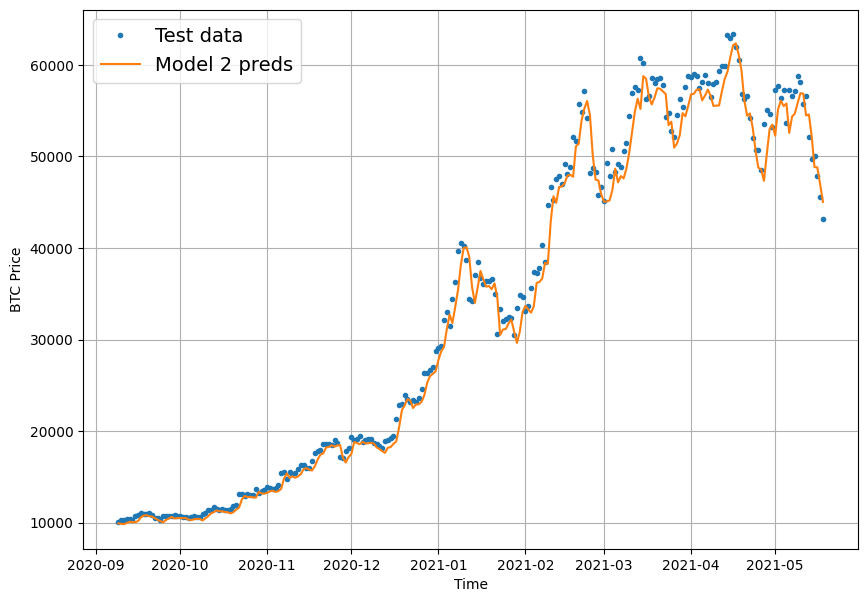

In [109]:
# Let's plot our model 1 predictions
offset = 300
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values= model_2_preds,
                 start = offset,
                 format="-",
                 label = "Model 2 preds")

## Model 3: Dense (window = 30, horizon = 7)

In [110]:
HORIZON = 7
WINDOW_SIZE = 30

In [111]:
# Make windowed  data
full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [112]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [113]:
tf.random.set_seed(42)

# Create model (same model as model as before)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name=("model_3_dense"))

model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [114]:
# Evaluate mmodel 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1323.8226


1323.8226318359375

In [115]:
# Load in best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1218.8137


1218.813720703125

In [116]:
# GEt forecast predictions
model_3_preds = make_preds(model_3,
                           test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9223.805 , 9274.4795, 9472.104 , 9658.435 , 9687.627 , 9379.734 ,
        9648.476 ],
       [8834.766 , 8955.52  , 9222.182 , 9342.099 , 9261.703 , 9259.062 ,
        9338.449 ],
       [8661.654 , 8664.862 , 9066.473 , 9138.291 , 8933.894 , 9085.087 ,
        9114.075 ],
       [8809.152 , 8799.002 , 9237.437 , 9147.833 , 9073.322 , 9097.827 ,
        9121.891 ],
       [8769.37  , 8905.726 , 9045.453 , 8999.339 , 8956.01  , 8867.724 ,
        8905.623 ]], dtype=float32)>

In [117]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)
model_3_results

{'mae': array([ 684.59344 ,  458.04617 ,  380.9622  ,  414.32883 ,  366.9728  ,
         475.8953  ,  561.20953 ,  626.5707  ,  570.4344  ,  586.37695 ,
         704.3805  ,  800.753   ,  791.4018  ,  866.89667 ,  584.243   ,
         209.88992 ,  154.56348 ,  263.60385 ,  287.90012 ,  326.50992 ,
         141.6757  ,  231.6531  ,  375.9615  ,  396.84732 ,  249.3217  ,
         128.87563 ,   90.06508 ,  102.356026,  122.355606,  197.85442 ,
         375.89285 ,  441.57993 ,  376.52078 ,  387.1434  ,  341.36057 ,
         330.4048  ,  346.16992 ,  217.73549 ,  213.03725 ,  177.4181  ,
         414.9179  ,  102.27839 ,   44.77204 ,  102.8254  ,  111.04381 ,
         126.61328 ,  153.74783 ,  133.59904 ,   59.553642,  137.07185 ,
         134.91441 ,  130.93324 ,  230.59787 ,  182.90855 ,  228.8697  ,
         318.6363  ,  526.2795  ,  528.82513 ,  467.18924 ,  510.21686 ,
         347.69427 ,  179.6326  ,  281.71344 ,  362.55093 ,  459.73416 ,
         394.44977 ,  455.3157  ,  592.88837

In [118]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

## Make our evaluation function work for larger horizons

In [119]:
# Create a function to take in model predictions and truth values and return evaluation
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluations metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrisc to single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [120]:
# Get model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)
model_3_results

{'mae': 1218.8137,
 'mse': 5227102.5,
 'rmse': 1406.7572,
 'mape': 5.4988704,
 'mase': 2.1688108}

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

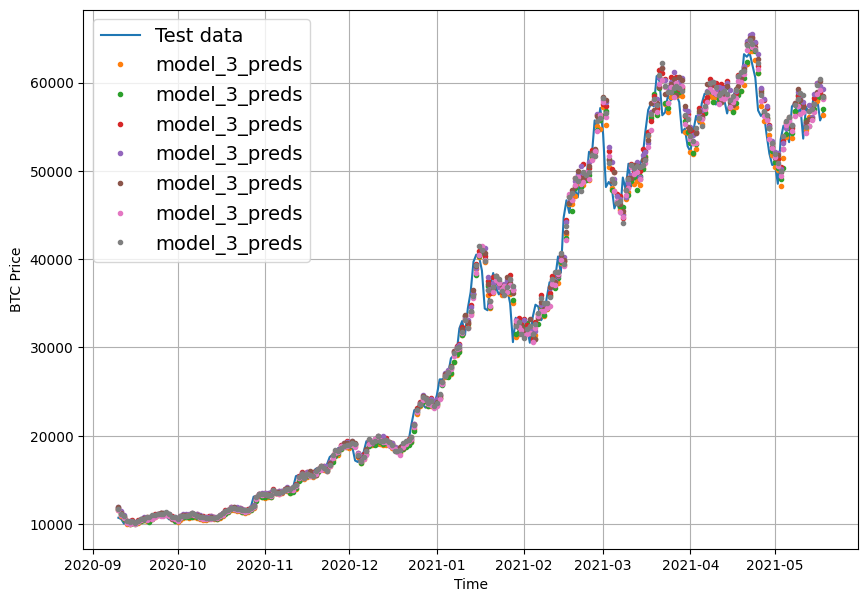

In [121]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values = test_labels[:, 0],
                 start=offset,
                 format="-",
                 label = "Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values = model_3_preds,
                 start=offset,
                 label="model_3_preds")

In [122]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9223.805 , 9274.4795, 9472.104 , 9658.435 , 9687.627 , 9379.734 ,
        9648.476 ],
       [8834.766 , 8955.52  , 9222.182 , 9342.099 , 9261.703 , 9259.062 ,
        9338.449 ],
       [8661.654 , 8664.862 , 9066.473 , 9138.291 , 8933.894 , 9085.087 ,
        9114.075 ],
       [8809.152 , 8799.002 , 9237.437 , 9147.833 , 9073.322 , 9097.827 ,
        9121.891 ],
       [8769.37  , 8905.726 , 9045.453 , 8999.339 , 8956.01  , 8867.724 ,
        8905.623 ]], dtype=float32)>

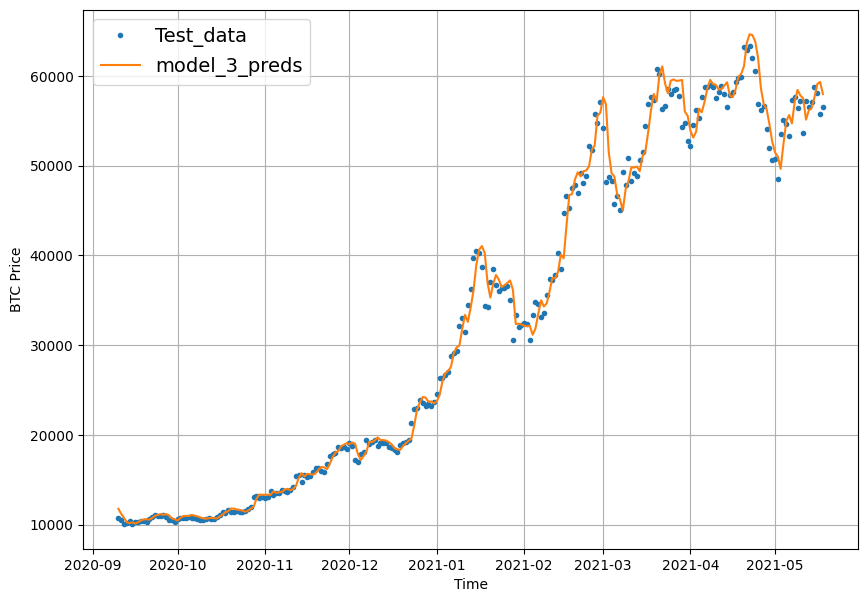

In [123]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

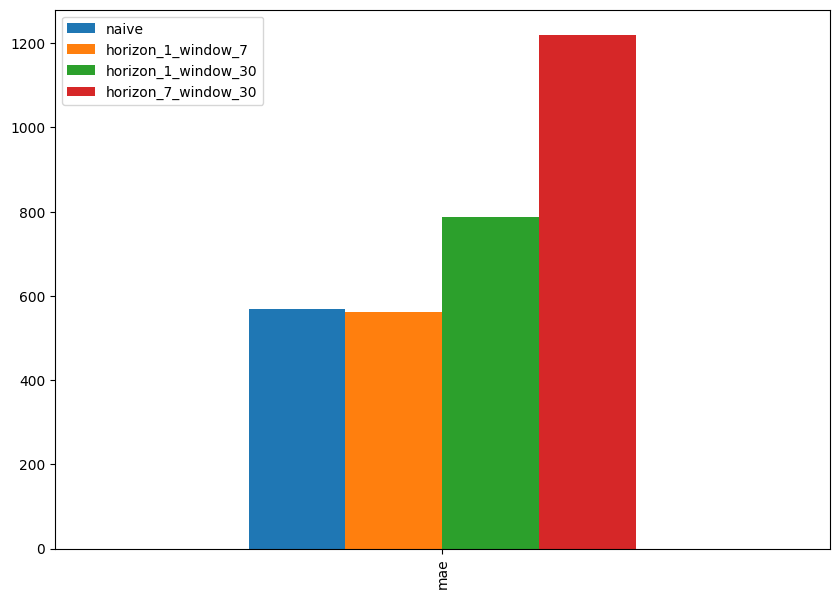

In [124]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index = ["mae"]).plot(figsize=(10,7), kind="bar");

> 🔑**Note:**  You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results

## Model 4: Conv1D



In [125]:
HORIZON = 1 #predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [126]:
#Create windowed data
full_windows, full_labels= make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [127]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows)  , len(train_labels) , len(test_windows)

(2224, 2224, 556)

To use the Conv1D layer,  we need an input shape of: `(batch_size, timesteps, input_dim)`.

How our data isn't in that shape yet..

In [128]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [129]:
# Before we pass our data to the Conv1D layer, we ha to reshaepe it in order to make sure it works
x =tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [130]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))  # add an extra dimension for `input_dim`

In [131]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape:{expand_dims_layer(x).shape}") #output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape:(7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [132]:
# Create Con1D

#lambda layer
#Conv1D model, fillters =128, kernel_size = 5, padding = ...
# output layer = dense

In [133]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size
    # kernel = same size as our sliding window
    layers.Conv1D(filters = 128, kernel_size=5, activation = "relu", padding = "causal"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile the model
model_4.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs =100,
            verbose =0,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

In [134]:
# Evaluate model 4
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 635.5979


635.597900390625

In [135]:
# Load in best performing model
model_4  = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 576.9240


576.9240112304688

In [136]:
# Get predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8888.671, 8788.497, 8982.066, 8749.586, 8735.104, 8752.893,
       8645.135, 8537.658, 8454.943, 8503.543], dtype=float32)>

In [137]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 576.924,
 'mse': 1201063.6,
 'rmse': 1095.9305,
 'mape': 2.5820148,
 'mase': 1.0134957}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previous.

In [138]:
tf.random.set_seed(42)

# Create model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences = True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_lstm")
# Compile the model
model_5.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[create_model_checkpoint(model_5.name)])


In [139]:
# Load best version
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.7857


585.7857055664062

In [140]:
# Make predictions
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8945.635 , 8824.966 , 9007.3545, 8795.564 , 8780.029 , 8783.9375,
       8706.59  , 8560.523 , 8503.848 , 8537.869 ], dtype=float32)>

In [141]:
# Evaluate model 5
model_5_results = evaluate_preds(tf.squeeze(test_labels),
                                   model_5_preds)
model_5_results

{'mae': 585.78564,
 'mse': 1228710.1,
 'rmse': 1108.4719,
 'mape': 2.6352315,
 'mase': 1.0290631}

> 🔑**Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probabably starting to clue into this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is wheter or not Daniel Bourk tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 -0

What's a better feature to use?

How about the bitcoin halving events?
https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [142]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [143]:
# Let's add the bitcoin halbing events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isnt' in our dataset (our data starts in 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 may 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")


In [144]:
# Create date ranges of where specific block_rewards values should be
# It calcualtes how many days have passed between the first date in bitcoin_prices and
# the block_reward_3_datetime
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days

(1012, 2421)

In [145]:
# Add in a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_rewards values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [146]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [147]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


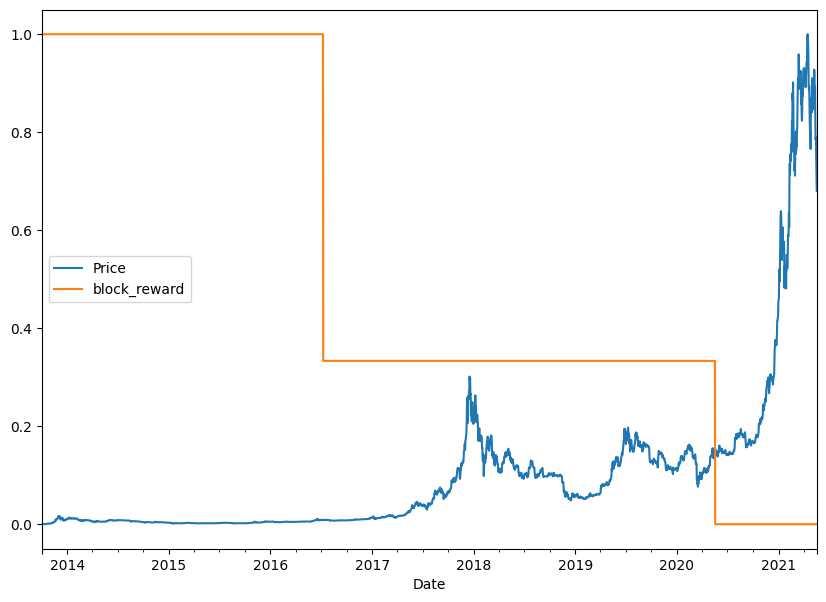

In [148]:
# Plot the block rewards vs price over time
# Let's adjust the scale in order to plot these
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                  columns = bitcoin_prices_block.columns,
                                                  index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset

Previously, we've turned our univariate time series into windowed dataset using the hepler functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [149]:
# Set up dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [150]:
# Make a copy of the Bitcoin historical data with block reward featture
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price +{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price +1,Price +2,Price +3,Price +4,Price +5,Price +6,Price +7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas datframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]

```

In [151]:
# create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price +1,Price +2,Price +3,Price +4,Price +5,Price +6,Price +7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [152]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [153]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len (y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [154]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# Construct the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_6_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 1,
            validation_data=(X_test, y_test),
            callbacks = [create_model_checkpoint(model_6.name)])

Epoch 1/100
18/18 [==============================] - 2s 84ms/step - loss: 880.5835 - val_loss: 2635.7205
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 236.4848 - val_loss: 1009.5458
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 181.1619 - val_loss: 1019.0743
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 167.7727 - val_loss: 986.8606
Epoch 5/100
18/18 [==============================] - 1s 33ms/step - loss: 151.4329 - val_loss: 800.8310
Epoch 6/100
18/18 [==============================] - 1s 44ms/step - loss: 135.9023 - val_loss: 740.4400
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 129.7063 - val_loss: 912.8732
Epoch 8/100
18/18 [==============================] - 1s 46ms/step - loss: 128.3440 - val_loss: 643.5215
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 122.2316 - val_loss: 766.8264
Epoch 10/100
18/18 [==============================] - 0s 7ms/ste

In [ ]:
# Best model load and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate")
model_6.evaluate(X_test, y_test)

In [ ]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

In [ ]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

In [ ]:
model_6_results

In [ ]:
model_1_results

In [160]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

For a challenge on different ways to potencially improve the multivariate time series model, see the referece here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

⚒**Exercises:**
 1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?

 Actually, in my case,  adding another layer decreases the performance. The results without an extra layer are:
 {'mae': 564.35126,
 'mse': 1153773.8,
 'rmse': 1074.1385,
 'mape': 2.5184107,
 'mase': 0.9914088}

 And the results with an extra layer are:{'mae': 565.5394,
 'mse': 1153536.0,
 'rmse': 1074.028,
 'mape': 2.559317,
 'mase': 0.9934961}

 Neverless both of them beat the results from the naive model

 2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitocoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`) works better? See [link text](https://https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-4-combining-pretrained-token-embeddings-character-embeddings-hybrid-embedding-layer) Model 4: Hybrid embedding section of notebook 09 for an idea on how to create a multi-input model

In [161]:
# 1. Set up price history inputs/model
window_size = 30
num_features = 1

price_input = layers.Input(shape=[window_size, num_features], name="price_input")
x = layers.Dense(128, activation = "relu")(price_input)
x = layers.GlobalAveragePooling1D()(x)
price_output = layers.Dense(HORIZON, activation="linear")(x)
price_model = tf.keras.Model(inputs = price_input,
                             outputs = price_output)

# 2. Set up block_reward inputs/model
block_reward_input = layers.Input(shape=(1,), name="block_reward_input")
x = layers.Dense(128, activation="relu")(block_reward_input)
block_reward_output = layers.Dense(HORIZON)(x)
block_reward_model = tf.keras.Model(inputs = block_reward_input,
                                    outputs = block_reward_output)

# 3. Concatenate
price_block_concat = layers.Concatenate(name = "price_block_hybrid")([price_model.output,
                                                                     block_reward_model.output])
z = layers.Dense(128, activation="relu")(price_block_concat)
final_output = layers.Dense(HORIZON)(z)

# 4. Define the model
model_hybrid = tf.keras.Model(inputs = [price_input, block_reward_input],
                              outputs = final_output)

# 5. Compile the model
model_hybrid.compile(loss = "mae",
                     optimizer = tf.keras.optimizers.Adam())

In [162]:
# Fit the model
#model_hybrid.fit(X_train,
#                 y_train,
#                 epochs = 100,
#                 batch_size =128,
#                 validation_data = (X_test,y_test))


## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it may perform really well...) time series forescating model we've built so far.

More specifically, we're going to be replicating the algortihm in Figure 1 in the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?
 * This will allow us to practice replicating a paper with TensorFlow code
 * We will see how to use TensorFlow layer subclassing (to make our own custom layers)
 * Get experience using the Fucntional API to create a custom architecture
 * Potentialy get state of the art results on our problem.

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [163]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers:int,
               **kwargs): # the *kwargs argument takes care of all the argumentes for the parente class(input_shape, trainable, shape..)
    super().__init__(**kwargs)
    self.input_size = input_size # in our case the window_size
    self.theta_size = theta_size # total number of parameters the block will output
    self.horizon = horizon #number of future time steps to forecast
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Create a stack(list) of hidden layers
    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]
    # Output of block is a theta laer with linear activation
    # The output of this layer is later split into two parts (backcast and forecast)
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="data")

  def call(self,inputs):
    x = inputs
    # Pass the inputs sequentiall through each hidden layer
    for layer in self.hidden:
      x = layer(x)
    # The theta layer outputs a vector containing parametes that will be split
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:,:self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


* Backcast: an approximation of the input (or a residual) that the model tries to "explain away".
The slice `theta[:, :self.input_size]` takes the first `input_size` elements of the theta vector for each sample. This is used to reconstruct or explain the input.
* Forescast: the predicted future values.
The slice `theta[:, -self.horizon:]` takes the last `horizon` elements of the theta vector for each sample, representing the forecasted values.

Setting up the `NBeatsBlock` custom layer we see:

* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs argument`
 * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
 * The hidden layers are created as a stack of fully connected with `n_neurons` hidden units layers with ReLU activation
 * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
 * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
 * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

Let's test our NBeastBlock class.

To do this we'll make some dummy inputs and outputs.

In [164]:
#Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                 theta_size = WINDOW_SIZE + HORIZON,# backcast + forecast
                                 horizon = HORIZON,
                                 n_neurons = 128,
                                 n_layers = 4)

In [165]:
# create dummy inputs (have to same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis= 0) #input shape to the model has to reflect dense layer input requirements
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [166]:
# Pass doummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_layer(dummy_inputs)
#These are going to be thea activation outputs of the theta laer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.44442254  0.29489687  0.37740853  0.19999468 -0.32084987  0.00394672
 -0.46655384]
Forecast: 2.091359853744507


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [168]:
# Create NBEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [169]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [170]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and teste sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [171]:
# Time to make our dataset perfomance using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_features_dataset))

# Batch and prefecth
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a few number of parameters, many of them can be found in Table 18 of the paper.

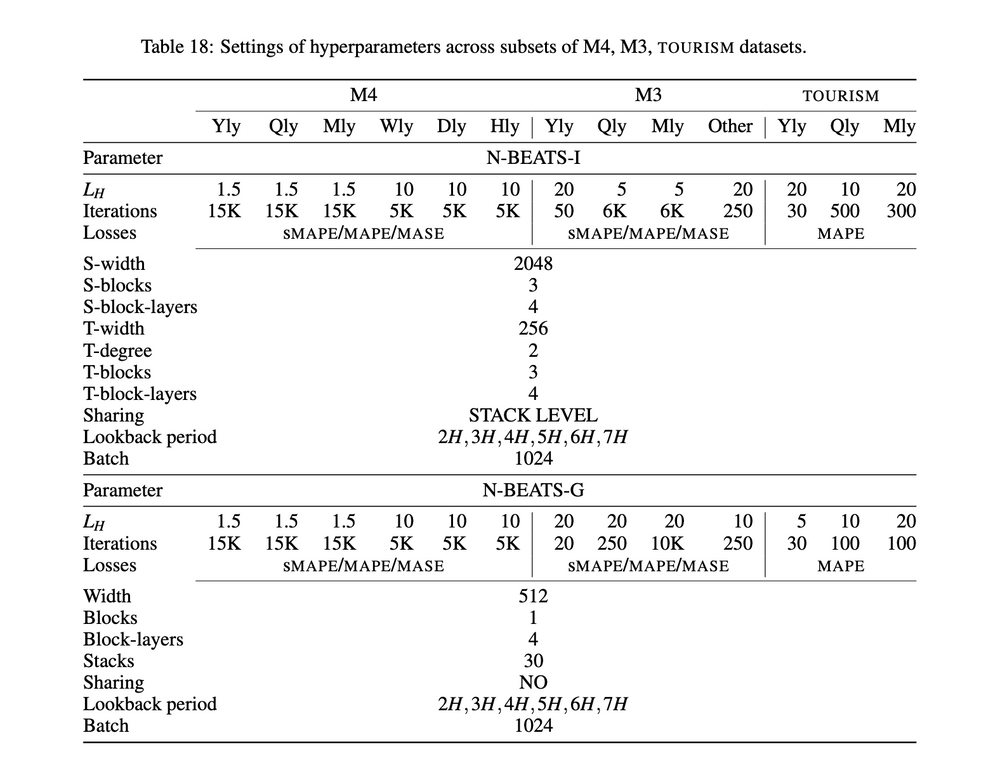

In [172]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE


(7, 8)

### Geting ready for the residual connections

Before we can craft our N-BEATS model, we need two layers fot the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

In [173]:
# Make tensonrs
tensor_1 = tf.range(10) +10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [174]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Set up and instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block used for the network, the rest will be created as part of the stacks)

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Funtional API)

3. Make the initial backcast and forecast for the model with the layer created in 1.

4. Use for loop to create stacks of block layers

5. Use the `NBeatsBlock` class within the foor loop in 4. to create block which return backast and block-level forecast

6. Create the double residual stacking using subtract and add layers.

7. Put the model inputs and outputs together using `tf.keras.Model()`

8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper

9. Fit the model for 500 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updated its weights each time (take smaller steps towards best perfomance)

In [175]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


KeyboardInterrupt: 

In [176]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 547ms/step - loss: 1289.4786 - mae: 1289.4786 - mse: 4672862.0000


[1289.4786376953125, 1289.4786376953125, 4672862.0]

In [177]:
# Make predictions
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8449.773 , 8325.77  , 8475.14  , 8371.275 , 8273.388 , 8267.77  ,
       8196.807 , 8090.4873, 8014.65  , 8047.5674], dtype=float32)>

In [178]:
# Evaluate model preds
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 1238.252,
 'mse': 3431745.8,
 'rmse': 1852.4972,
 'mape': 6.188612,
 'mase': 2.1752658}

In [179]:
model_1_results

{'mae': 562.74225,
 'mse': 1152376.6,
 'rmse': 1073.488,
 'mape': 2.5171854,
 'mase': 0.98858225}

In [180]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Even with all those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perfomr as well as `model_1` or the original naive forecast.

This goes to sow the power of smaller networkds as well as the fact not all larger models are better suited for a certain type of data.

### Plot the N-BEATS architecture we've created

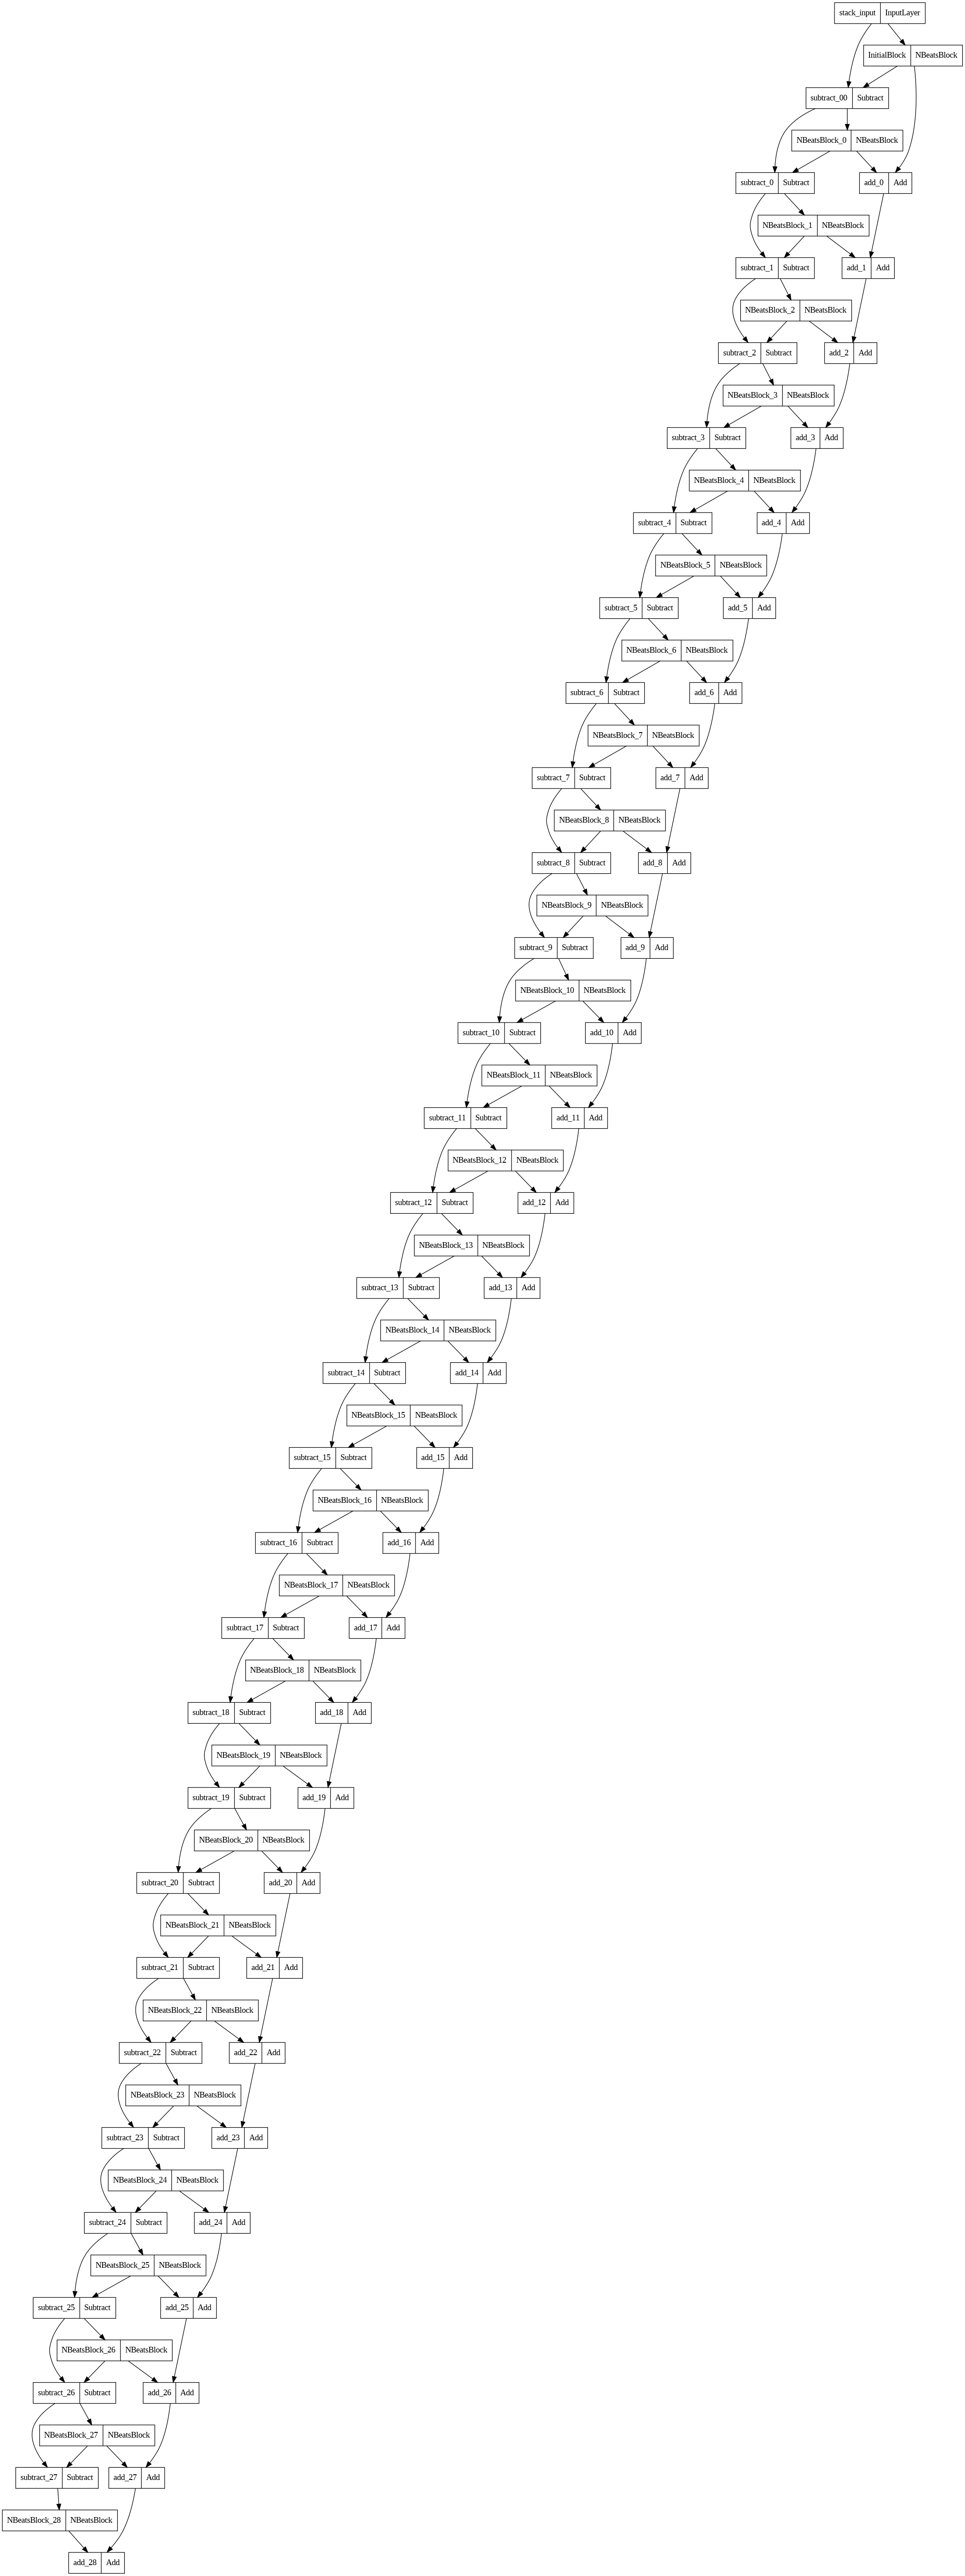

In [181]:
# Plot te N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An **ensemble** involves training and combining multiple different models on the same problem.

An ensemble leverages the wisdom of the crowd effect.

It combines many *diferent* models to predict a common goal.

## Constructing and fitting an ensemble of models (using different loss functions)

In [182]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter=10, #how many different models we are goin to train
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter = 10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """

  # Make empty list for trained ensemble model
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number{i}")

      # Construct a simple model(similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics = ["mae", "mse"])

      # Fit the current model
      model.fit(train_dataset,
                epochs = num_epochs,
                verbose=0,
                validation_data=test_dataset,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience = 200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to ensembel models
      ensemble_models.append(model)

  return ensemble_models

In [183]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number0

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 205: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number0

Epoch 118: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 218: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number0

Epoch 114: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 214: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number1

Epoch 403: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 511: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 611: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by

### Make predictions with our ensembe model

In [184]:
# Createa a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [185]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data = test_dataset)
ensemble_preds

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 48ms/step
CPU times: user 802 ms, sys: 102 ms, total: 904 ms
Wall time: 900 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 9247.197,  8913.441,  8825.064, ..., 52527.812, 52887.492,
        49744.707],
       [ 9342.16 ,  9263.737,  8869.588, ..., 53521.902, 51716.484,
        52246.902],
       [ 9433.892,  9305.086,  9041.814, ..., 54849.36 , 54545.027,
        50828.195],
       ...,
       [ 9391.393,  9320.732,  9080.341, ..., 55003.664, 51055.23 ,
        49196.016],
       [ 8964.925,  9112.74 ,  9192.174, ..., 54837.812, 51910.37 ,
        51788.53 ],
       [ 8756.122,  8706.809,  8968.77 , ..., 49867.473, 48818.246,
        46268.574]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine them into **point predictions** we can leverage the mean of all the predictions or the median: https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [186]:
ensemble_mean = tf.reduce_mean(ensemble_preds,axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9094.457, 9082.595, 9018.67 , 8771.221, 8870.423, 8754.235,
       8703.862, 8623.901, 8589.27 , 8537.727], dtype=float32)>

In [187]:
ensemble_median = np.median(ensemble_preds,axis=0)
ensemble_median[:10]

array([8972.568, 9087.789, 9041.814, 8762.502, 8881.166, 8668.701,
       8711.125, 8604.425, 8605.938, 8532.157], dtype=float32)

In [188]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred = ensemble_mean)
ensemble_results

{'mae': 898.05835,
 'mse': 2536264.2,
 'rmse': 1592.5653,
 'mape': 3.9699798,
 'mase': 1.5776398}

In [189]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred = ensemble_median)
ensemble_results

{'mae': 889.0153,
 'mse': 2519372.0,
 'rmse': 1587.2529,
 'mape': 3.9038908,
 'mase': 1.5617536}

In [190]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred = ensemble_preds)
ensemble_results

{'mae': 1012.66327,
 'mse': 3416298.8,
 'rmse': 1787.3258,
 'mape': 4.539865,
 'mase': 1.7789689}

In [191]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [192]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 211: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 115: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 215: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 205: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 216: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 133: ReduceLROnPl

In [193]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 889.0153,
 'mse': 2519372.0,
 'rmse': 1587.2529,
 'mape': 3.9038908,
 'mase': 1.5617536}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow' price of Bitcoin will be $50,000USD.

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning
model is the boostrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standar deviation of the predictions
3. Multiply the standar deviation by 1.96(assuming the distribution of our data is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in 3. to the mean/median of the predictions made in 1.




In [194]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized
  # 2. Measure the standar deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standar deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval uppera and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower,upper = preds_mean - interval, preds_mean + interval

  return lower, upper



In [195]:
# Get the upper and lower bounds of the 95% percent predictions interval
lower,upper = get_upper_lower(preds = ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8572.607 ,  8623.85  ,  8692.955 ,  8351.967 ,  8389.524 ,
         8394.422 ,  8359.934 ,  8326.401 ,  8196.957 ,  8333.074 ,
         8002.823 ,  7921.597 ,  7883.2153,  7344.99  ,  7086.521 ,
         7026.027 ,  6697.8755,  6893.292 ,  6687.798 ,  6956.4536,
         6853.3237,  7135.818 ,  7086.0474,  7132.051 ,  7111.686 ,
         7050.564 ,  7022.8037,  7077.045 ,  7047.6895,  7151.661 ,
         7191.074 ,  7153.7217,  7075.137 ,  7054.589 ,  6999.483 ,
         7012.77  ,  6843.528 ,  6928.9497,  6741.372 ,  6412.14  ,
         6735.324 ,  6300.9365,  6661.3457,  6609.4424,  6680.2544,
         6674.176 ,  6946.5347,  7017.8657,  7026.292 ,  7019.597 ,
         7059.924 ,  7078.2026,  7050.8403,  7020.8115,  7034.6763,
         6785.9624,  7015.1973,  6800.5986,  6975.7847,  6916.9756,
         6976.446 ,  7173.8066,  7429.677 ,  7691.137 ,  7522.0137,
         7781.767 ,  7745.8423,  7887.3657,  7681.4585,  8109.33  ,

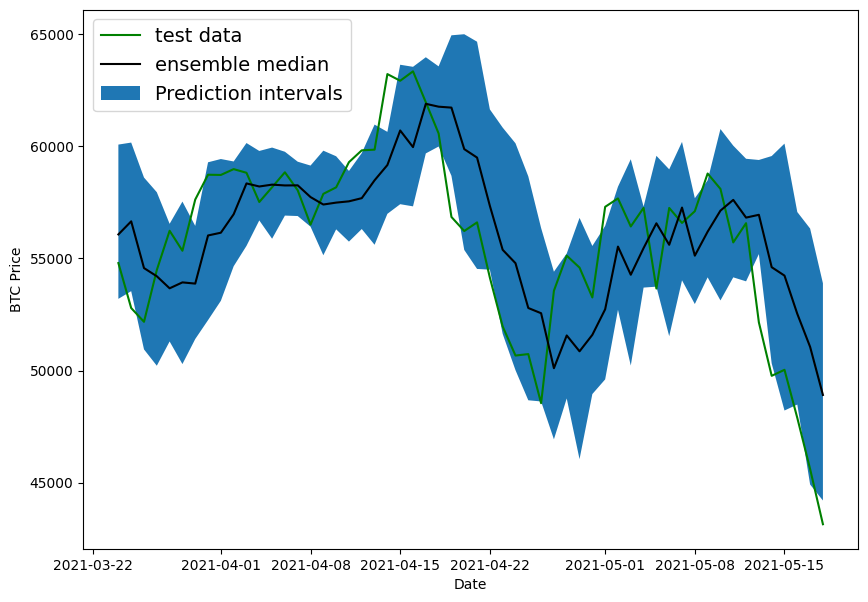

In [196]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
#(where the predictions fall between)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:],"g", label="test data")
plt.plot(X_test.index[offset:],ensemble_median[offset:], "k-", label="ensemble median" )
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predictions have benn laggind behing the test data...

As in they're replicating what the naive model does and just predict the previous timesteps as the next timestep

> 🔑 **Note:** These prediction interval are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudo future.

Let's now build a model which is capablae of predicting into the future!

In [197]:
HORIZON= 1
WINDOW_SIZE = 7

In [198]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price +1,Price +2,Price +3,Price +4,Price +5,Price +6,Price +7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [199]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"],axis=1).to_numpy()

# GEt labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)


(2780, 2780)

In [200]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [201]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefecth for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [202]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
    layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_9")

model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs =100,
            verbose=0)




### Make predictions into the future

In [203]:
# How many timesteps to predict into the future?
INTO_FUTURE = 50

To make predictions into the future we want a function which:

1. Takes as inputs:
 * a list of values (Bitcoin historical data)
 * a trained model(such as `model_9`)
 * a window into the future to predict (our `INTO_FUTURE` variable)
 * the window size a model was trained on(`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecast - this will be returned at the end of the function, when it's full of predictions, and extracts the last `WINDOW_SIZE` values from the input values.

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest predictions

In [204]:
# 1. Create a function to make predictions into the future
def make_future_forecast(values, model, into_future,window_size = WINDOW_SIZE) -> list:
  """
  Make future forecast into future steps after values ends.

  Returns future forecast as a list of floats.
  """

  # 2. Create an empty list for future forecast/prepare data to forecast on
  future_forecast = []
  last_window  = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model
    # will eventually start to make forecast on its own forecast)
    future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDO_SIZE windows)
    last_window = np.append(last_window,future_pred)[-WINDOW_SIZE:]

  return future_forecast

🛠 Exercise: In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.

So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.

As it is, the make_future_forecasts() function skips the retraining of a model part.

In [205]:
# MAke forecast into the future
future_forecast = make_future_forecast(values = y_all,
                                       model = model_9,
                                       into_future = INTO_FUTURE,
                                       window_size = WINDOW_SIZE)

1/1 [==============================] - 0s 79ms/step
Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 54206.80078125

1/1 [==============================] - 0s 23ms/step
Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 54206.80078125] -> Prediction: 52018.2265625

1/1 [==============================] - 0s 23ms/step
Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 54206.80078125 52018.2265625 ] -> Prediction: 48648.22265625

1/1 [==============================] - 0s 23ms/step
Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 54206.80078125 52018.2265625  48648.22265625] -> Prediction: 50052.94921875

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 54206.80078125
 52018.2265625  48648.22265625 50052.9492187

### Plot future forecast

In [206]:
future_forecast[:10]

[54206.8,
 52018.227,
 48648.223,
 50052.95,
 45220.25,
 42037.645,
 48896.516,
 53787.38,
 50888.785,
 49053.133]

In [207]:
# Plot
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") #specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") #specificy end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") #retunr a date between start and end date



In [208]:
# Last timestpe of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [209]:
# GEt next to week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future = INTO_FUTURE,
                                   offset=1)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
       '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
       '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
       '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
       '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
       '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23',
       '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27',
       '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
       '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05',
       '2021-07-06', '2021-07-07'], dtype='datetime64[D]')

In [210]:
# insert last timestep/final price into next timesteps and future forecast
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices[-1])

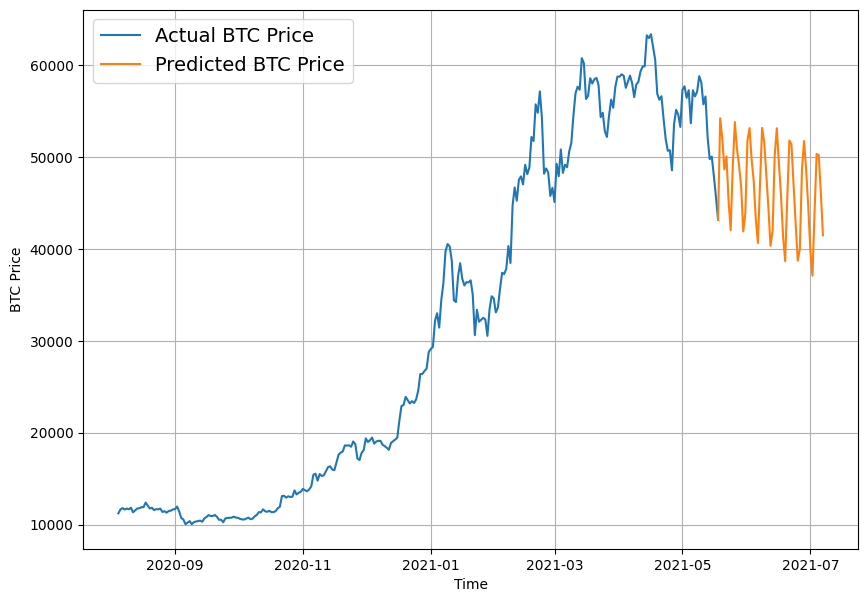

In [211]:
# Plot future prices predictions
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [212]:
# Let's introduce a turkey problem to our BTC data(price of BTC falls 100x in one day)
btc_price_turkey = btc_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] /100

In [213]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [214]:
# Ge the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

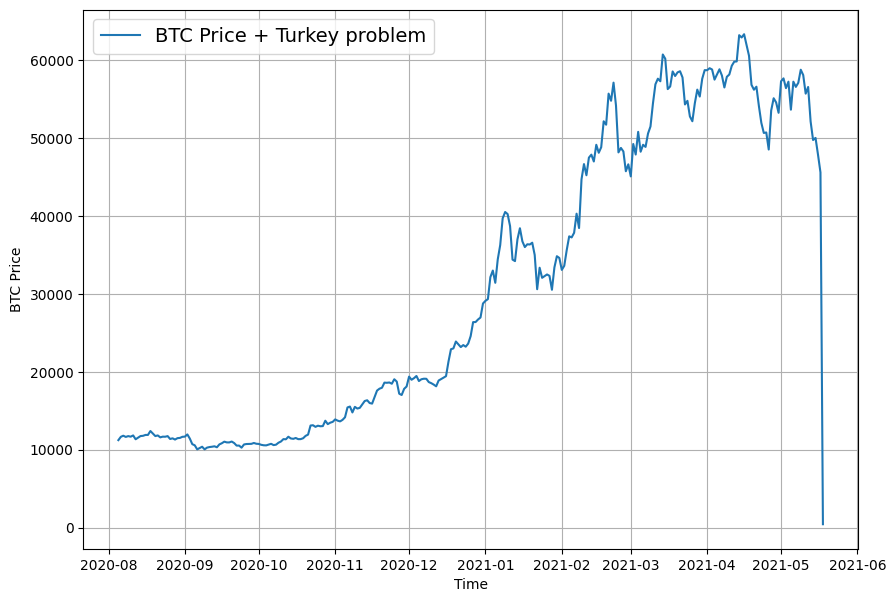

In [215]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values = btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start = 2500)

In [216]:
HORIZON = 1
WINDOW_SIZE = 7

In [217]:
#Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size = WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Build a turkey model (model to predict on turkey data)

In [218]:
# Clone model 1 architecture for turkey model and fit the turkey model on turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

turkey_model.fit(X_train, y_train,
                 epochs = 100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [219]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)


18/18 [==============================] - 0s 2ms/step - loss: 746.5886


746.588623046875

In [220]:
# Load best perfoming turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_Turkey_Model")
turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 647.2453


647.2453002929688

In [221]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model,
                          X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8858.103 , 8772.098 , 9034.549 , 8772.44  , 8717.242 , 8744.301 ,
       8693.062 , 8490.9375, 8473.013 , 8521.498 ], dtype=float32)>

In [222]:
# evaluate turkey preds
turkey_results = evaluate_preds(y_true = y_test,
                                y_pred = turkey_preds)
turkey_results

{'mae': 17129.164,
 'mse': 614469250.0,
 'rmse': 23715.488,
 'mape': 121.36029,
 'mase': 26.507439}

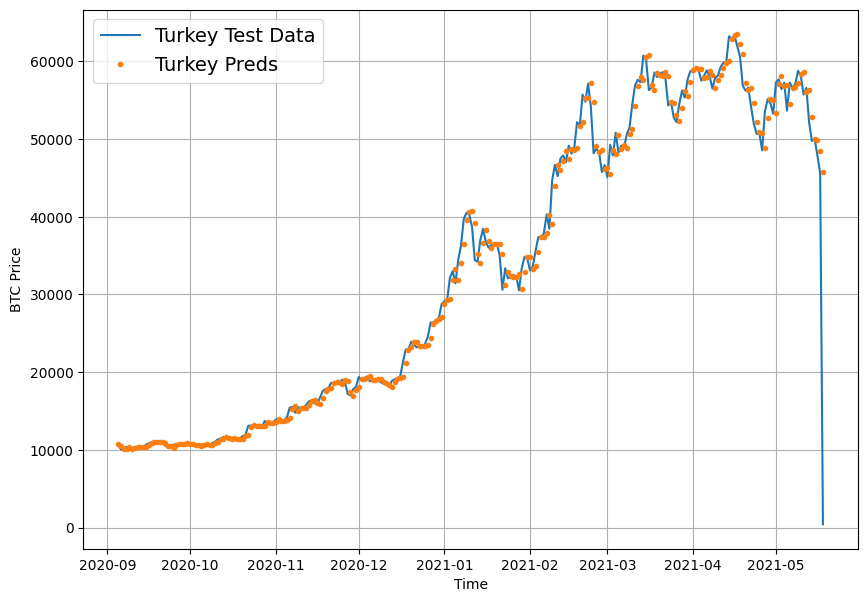

In [223]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare models

In [224]:
# Compare differente model results (w = window, h=horizon)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w1_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LTSM": model_5_results,
                              "model_6_multivariate":model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble":ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w1_h1,562.742249,1.152377e+06,1073.488037,2.517185,0.988582
model_2_dense_w30_h1,786.805420,1.743958e+06,1320.589966,3.736234,1.375343
model_3_dense_w30_h7,1218.813721,5.227102e+06,1406.757202,5.498870,2.168811
model_4_CONV1D,576.924011,1.201064e+06,1095.930542,2.582015,1.013496
model_5_LTSM,585.785645,1.228710e+06,1108.471924,2.635231,1.029063
model_6_multivariate,568.453003,1.163539e+06,1078.674683,2.569557,0.998614
model_7_NBEATS,1238.251953,3.431746e+06,1852.497192,6.188612,2.175266
model_8_ensemble,889.015320,2.519372e+06,1587.252930,3.903891,1.561754
model_10_turkey,17129.164062,6.144692e+08,23715.488281,121.360291,26.507439


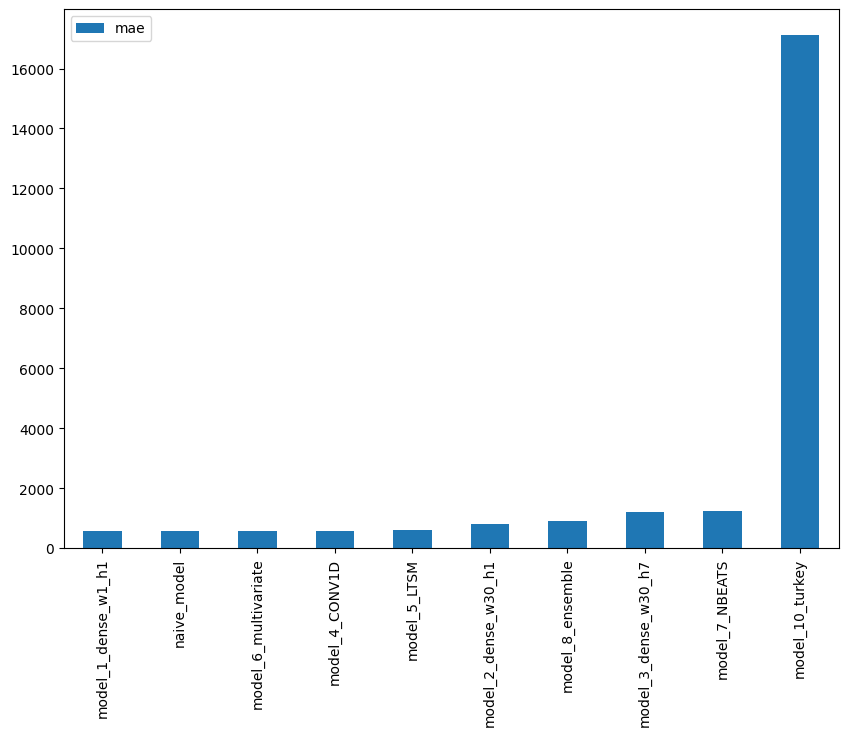

In [225]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar");

In [226]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [227]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [228]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [229]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [230]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [231]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [232]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [233]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

KeyboardInterrupt: 

In [234]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 3s 3s/step - loss: 486011.0625 - mae: 486011.0625 - mse: 417549713408.0000


[486011.0625, 486011.0625, 417549713408.0]

In [235]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([235946.3 , 234047.56, 233209.47, 231370.97, 228933.53, 226257.81,
       225194.28, 223516.53, 222458.56, 220414.8 ], dtype=float32)>

In [236]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 486011.06,
 'mse': 417549700000.0,
 'rmse': 646180.9,
 'mape': 2431.377,
 'mase': 853.7868}

In [237]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [238]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 955: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 483: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 583: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 451: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 551: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 308: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 953: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 265: ReduceLROnPl

In [239]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [240]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 889.0153,
 'mse': 2519372.0,
 'rmse': 1587.2529,
 'mape': 3.9038908,
 'mase': 1.5617536}

In [241]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

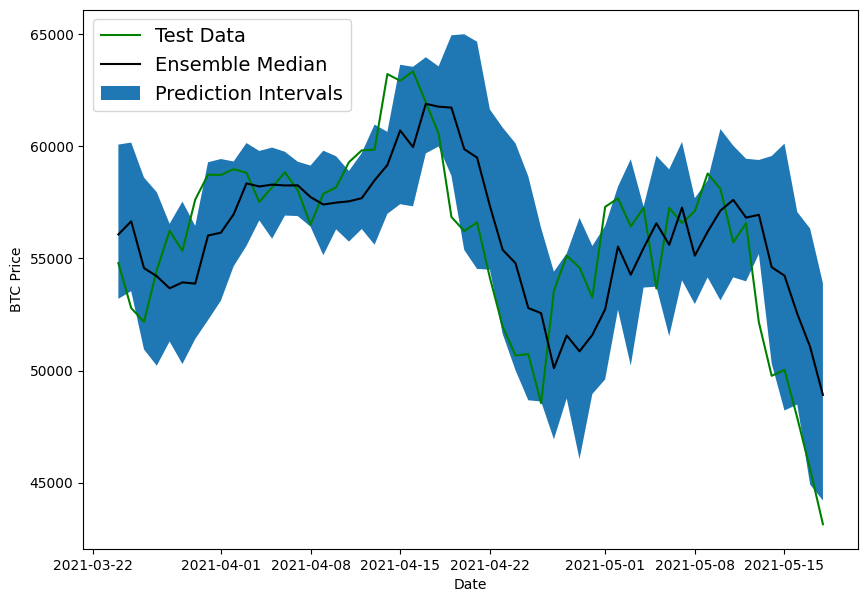

In [242]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);